In [ ]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
rcParams['figure.figsize'] = 10, 6
df = pd.read_csv('https://raw.githubusercontent.com/raditya2010631170111/df_20111/main/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#DM Prak 9

In [ ]:
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) 
indexedData = df.set_index(['Month'])
indexedData.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


EDA explorasi data analysis

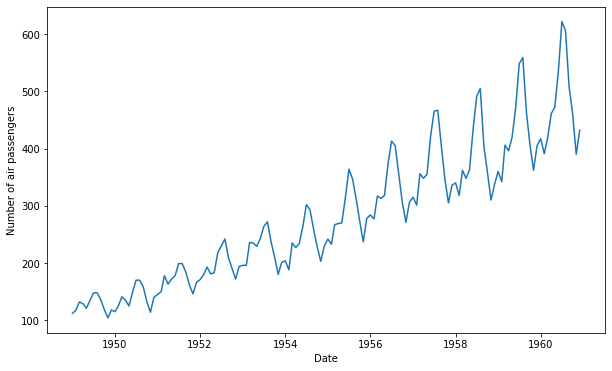

In [ ]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedData)

1.   tiap naik=bulan
2.   awal tahun=naik
3. pertengan tahun=tertinggi
4. akhir tahun=turun = sifat seasonal data vs sifat stationer=tdk berpola


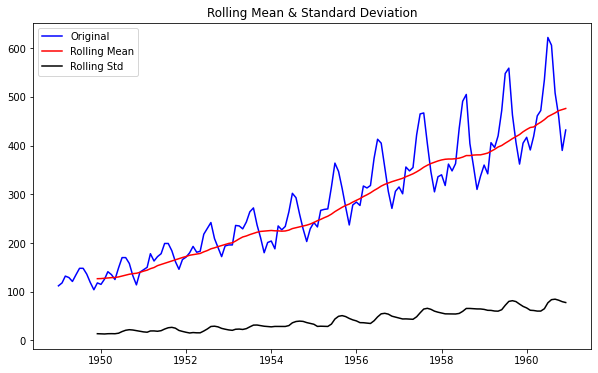

In [ ]:
rolmean = indexedData.rolling(window=12).mean() #determine rolling statistics: windows=1 #/bulan
rolstd = indexedData.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(indexedData, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


1.   garis mean 1950=mean 12 bulan sebelumnya
2.   Augmented Dickey–Fuller test



In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedData['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


1. H0 (Hipotesis null)           = data non stationer       | GAGAL DITOLAK p-value >  confidence interval=0.5
2. Ha (Hipotesis alternative) = data BUKAN non stationer | GAGAL DITOLAK p-value <=  confidence interval=0.5

3. critical value 1-10% == Test Statistic = stationary
4. tingkat keyakinan/confidence=90% = sisa 5%=0.05

Data Transformation dgn Log Scale

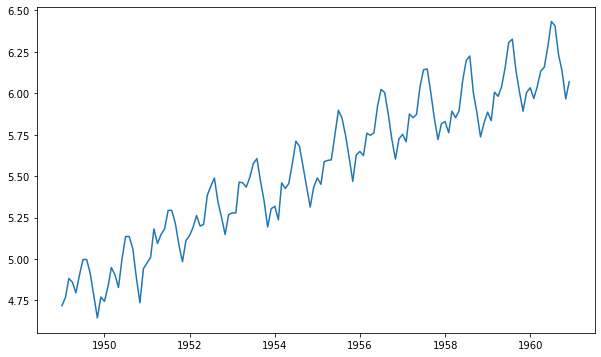

In [ ]:
indexedDataset_logScale = np.log(indexedData)
plt.plot(indexedDataset_logScale)

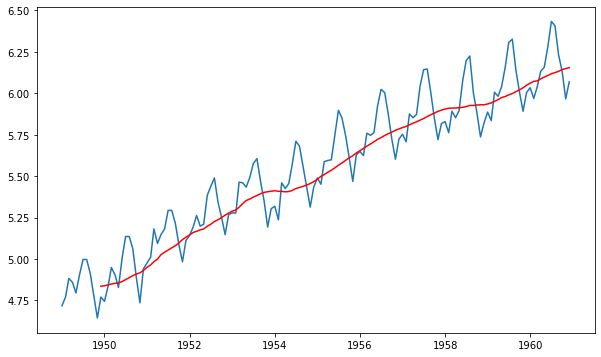

In [ ]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True) #alternative: .fillna()
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1950-11-01,4.688682
1950-12-01,4.887766
1951-01-01,4.912854
1951-02-01,4.942295
1951-03-01,5.105253
1951-04-01,5.013736
1951-05-01,5.055094
1951-06-01,5.089326
1951-07-01,5.202615


non stationary > stationary

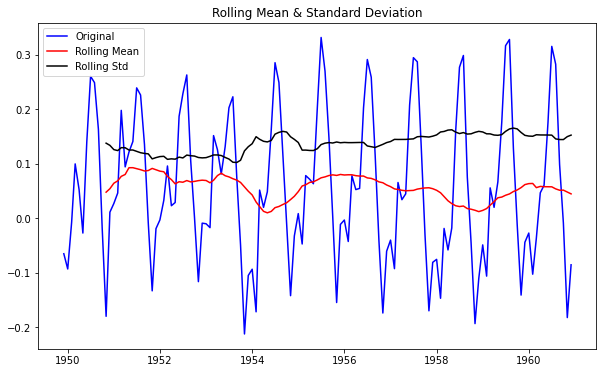

In [ ]:
#Determine rolling statistics
movingAverage = datasetLogScaleMinusMovingAverage.rolling(window=12).mean()
movingSTD = datasetLogScaleMinusMovingAverage.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(datasetLogScaleMinusMovingAverage, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(datasetLogScaleMinusMovingAverage['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


Time Shifting

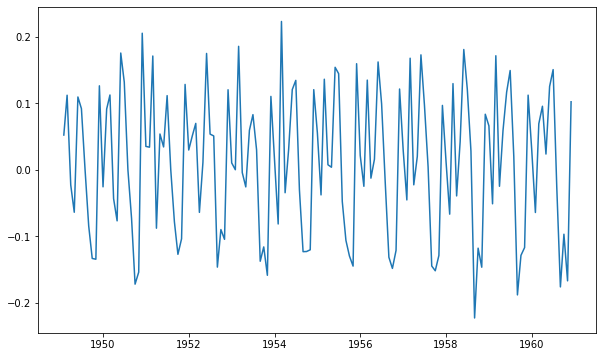

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

Seasonal Decomposition

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


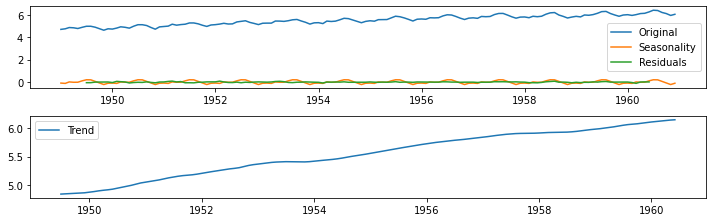

In [ ]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

Modelling ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

Plotting ARIMA model


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


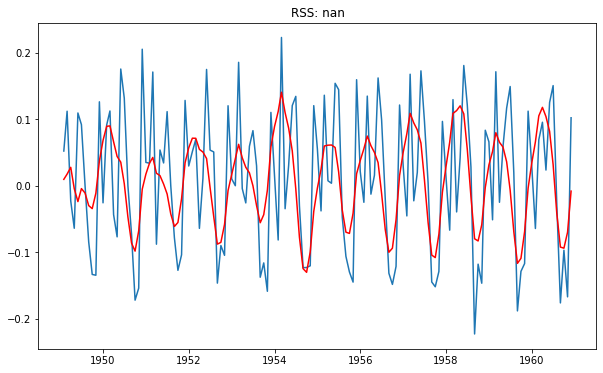

In [ ]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)

plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Convert Back To Original Time Series (Before Transformation)

In [ ]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [ ]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

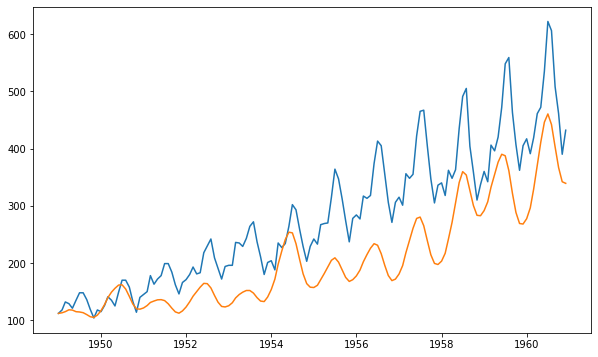

In [ ]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedData)
plt.plot(predictions_ARIMA)

Forecast

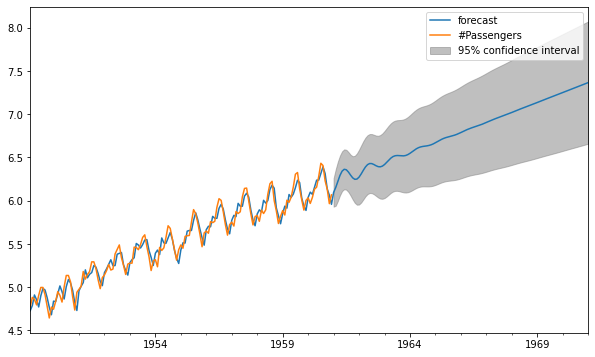

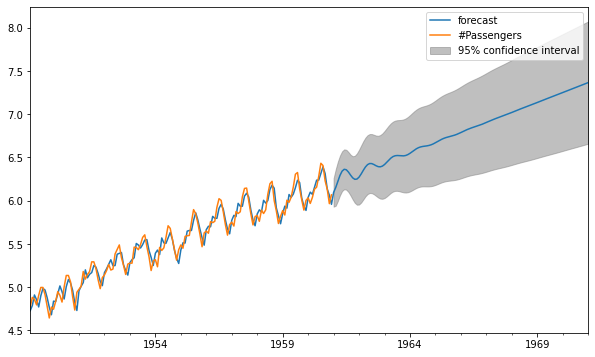

In [ ]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) #12 x 120 = 264

1. abu-abu=confidence=perkiraan apabila forecast salah tdk akan melebihi batas melesatan itu
2. mirip MAE=bisa lebih atau kurang: MAE = 100

#DM Prak 10

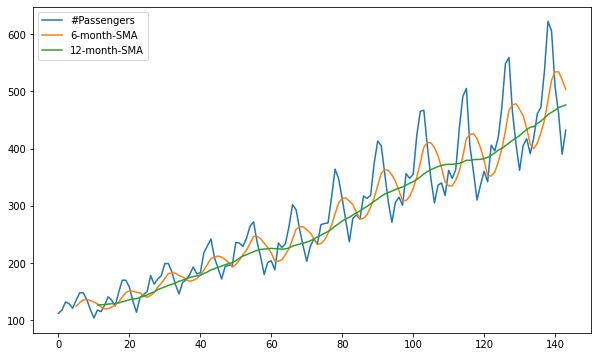

In [ ]:
# Statistical Approach
# Simple Moving Average
df_sma = df.copy()
df_sma['6-month-SMA'] = df['#Passengers'].rolling(window=6).mean()
df_sma['12-month-SMA'] = df['#Passengers'].rolling(window=12).mean()
df_sma.plot()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


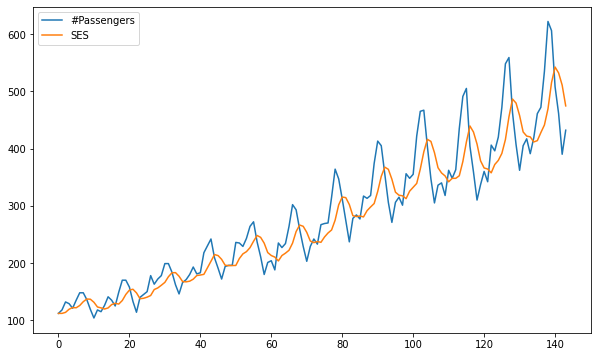

In [ ]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
df_ses = df.copy()
model_ses = SimpleExpSmoothing(df['#Passengers'])
fitted_model_ses = model_ses.fit(smoothing_level=0.3,optimized=False,use_brute=True) # bisa masukin alpha
df_ses['SES'] = fitted_model_ses.fittedvalues
df_ses.plot()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


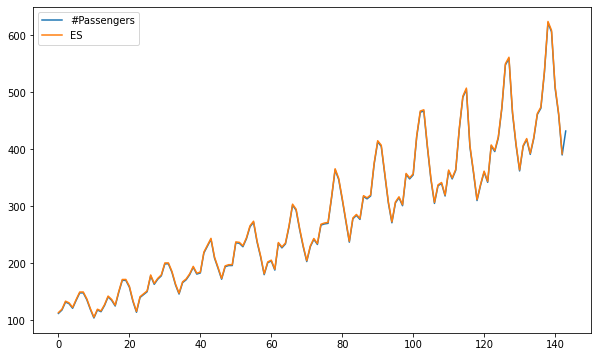

In [ ]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df_es = df.copy()
model = ExponentialSmoothing(df['#Passengers'], trend = 'add') # try mul
fitted_model = model.fit()
df_es['ES'] = fitted_model.fittedvalues.shift(-1)
df_es.plot()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


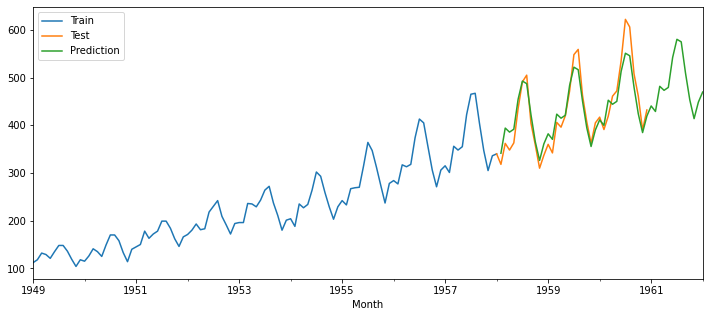

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', parse_dates = ['Month'], index_col = ['Month'])
train = df.iloc[:109] # df.loc[:'1940-01-01']
test = df.iloc[108:]
fitted_model = ExponentialSmoothing(train['Passengers'],
                                   trend = 'add', # try mul
                                   seasonal = 'add', # try mul
                                   seasonal_periods = 12).fit()
test_predictions = fitted_model.forecast(48)
train['Passengers'].plot(legend=True, label = 'Train',
                             figsize = (12,5))
test['Passengers'].plot(legend=True, label = 'Test')
test_predictions.plot(legend=True, label = 'Prediction')

In [ ]:
# performance
print("Exponential Smoothing")
print("MAE: ",mean_absolute_error(test['Passengers'],test_predictions[:36]))
print("MSE: ",mean_squared_error(test['Passengers'],test_predictions[:36]))
print("RMSE: ", np.sqrt(mean_squared_error(test['Passengers'],test_predictions[:36])))
print("R2: ",r2_score(test['Passengers'],test_predictions[:36]))
print("")

Exponential Smoothing
MAE:  45.89218848495844
MSE:  3083.017578662589
RMSE:  55.524927543064734
R2:  0.49609944278393525



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

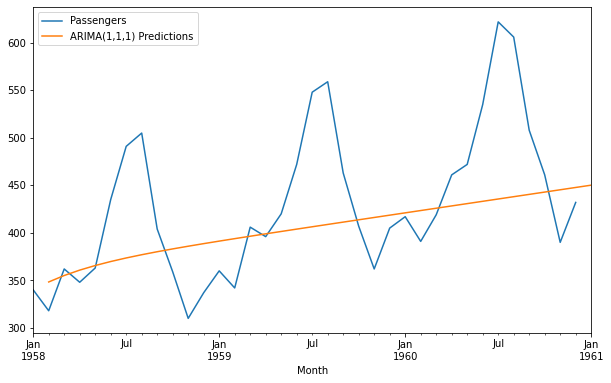

In [ ]:
# ARIMA
start=len(train)
end=len(train)+len(test)-1
model=ARIMA(train['Passengers'],order=(1,1,1)) # (p -> AR, d -> I (stationarity) , q -> MA)
results=model.fit()
# predictions
predictions=results.predict(start,end,typ='levels').rename('ARIMA(1,1,1) Predictions')
test['Passengers'].plot(legend=True)
predictions.plot(legend=True)

In [ ]:
print("ARIMA")
print("MAE: ",mean_absolute_error(test['Passengers'],predictions))
print("MSE: ",mean_squared_error(test['Passengers'],predictions))
print("RMSE: ", np.sqrt(mean_squared_error(test['Passengers'],predictions)))
print("R2: ",r2_score(test['Passengers'],predictions))
print("")

ARIMA
MAE:  52.165824636674536
MSE:  5094.947964941213
RMSE:  71.37890420103977
R2:  0.1672616023050877



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

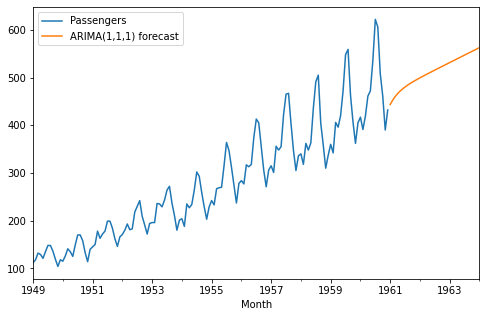

In [ ]:
# Forecast into future
model=ARIMA(df['Passengers'],order=(1,1,1))
results=model.fit()
fcast=results.predict(start=len(df),end=len(df)+36,typ='levels').rename('ARIMA(1,1,1) forecast')
df['Passengers'].plot(legend=True,figsize=(8,5))
fcast.plot(legend=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


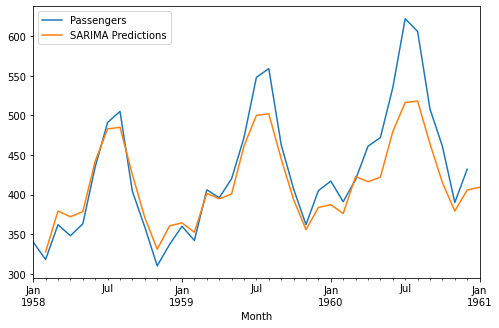

In [ ]:
model=SARIMAX(train['Passengers'],order=(1,1,1),seasonal_order=(1,0,0,12))
results=model.fit()
predictions1=results.predict(start,end,typ='levels').rename('SARIMA Predictions')
test['Passengers'].plot(legend=True,figsize=(8,5))
predictions1.plot(legend=True)

In [ ]:
print("SARIMAX")
print("MAE: ",mean_absolute_error(test['Passengers'],predictions1))
print("MSE: ",mean_squared_error(test['Passengers'],predictions1))
print("RMSE: ", np.sqrt(mean_squared_error(test['Passengers'],predictions1)))
print("R2: ",r2_score(test['Passengers'],predictions1))
print("")

SARIMAX
MAE:  42.74064650940362
MSE:  2953.9631843663788
RMSE:  54.3503742799107
R2:  0.5171926021765756



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


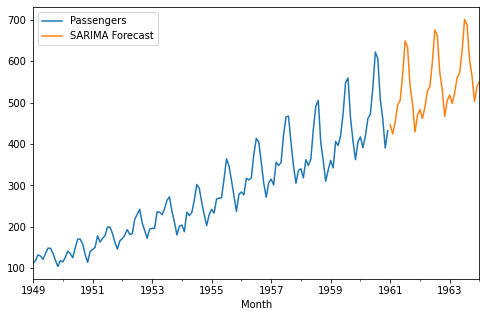

In [ ]:
model=SARIMAX(df['Passengers'],order=(1,1,1),seasonal_order=(1,0,0,12))
results=model.fit()
fcast=results.predict(start=len(df),end=len(df)+36,typ='levels').rename('SARIMA Forecast')
df['Passengers'].plot(legend=True,figsize=(8,5))
fcast.plot(legend=True)

In [ ]:
# Machine Learning Approach
# Basic model
df_ml = df.copy()
df_ml.drop(['Month'], axis=1, inplace=True)
df_ml.head()

KeyError: ignored

In [ ]:
def LaggedFeatures(s,lag=2,fillna=True, dropna=False):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)
    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        res = res.dropna()
    else:
        res = res
    if fillna:
        return res.fillna(0)
    else:
        return res 
lag1 = LaggedFeatures(df_ml,lag=3,fillna=True, dropna=True)
lag1.shape

(141, 4)

In [ ]:
train = lag1.iloc[:101]
test = lag1.iloc[101:]
train.head()

,Passengers,Passengers_lag1,Passengers_lag2,Passengers_lag3
Month,,,,
1949-04-01,129,132.0,118.0,112.0
1949-05-01,121,129.0,132.0,118.0
1949-06-01,135,121.0,129.0,132.0
1949-07-01,148,135.0,121.0,129.0
1949-08-01,148,148.0,135.0,121.0


In [ ]:
X_train = train.drop(['Passengers'], axis=1)
X_test = test.drop(['Passengers'], axis=1)
y_train = train['Passengers']
y_test = test ['Passengers']
X_train = X_train.astype(float).values
y_train = y_train.astype(float).values
X_test = X_test.astype(float).values
y_test = y_test.astype(float).values
# call model
rf = RandomForestRegressor()
lr = LinearRegression()
#train
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
# performance
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test)
print("Random Forest Regression")
print("MAE: ",mean_absolute_error(y_test,y_pred_rf))
print("MSE: ",mean_squared_error(y_test,y_pred_rf))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print("R2: ",r2_score(y_test,y_pred_rf))
print("")
print("Linear Regression")
print("MAE: ",mean_absolute_error(y_test,y_pred_lr))
print("MSE: ",mean_squared_error(y_test,y_pred_lr))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_lr)))
print("R2: ",r2_score(y_test,y_pred_lr))
print("")

Random Forest Regression
MAE:  47.56575
MSE:  3800.471102500001
RMSE:  61.647961057118515
R2:  0.38879009472177095

Linear Regression
MAE:  39.499299468627996
MSE:  2102.168584776421
RMSE:  45.8494120439556
R2:  0.6619192129273492



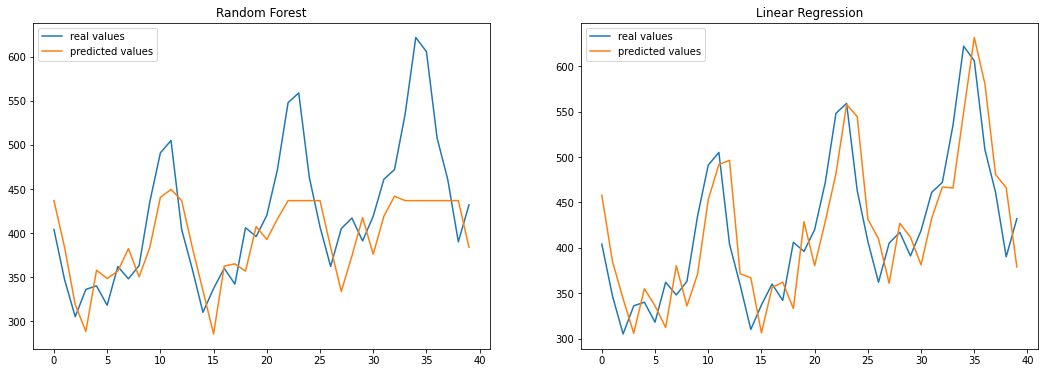

In [ ]:
#Plot untuk melihat hasil
fig, axs = plt.subplots(1, 2, figsize=(18,6)) 
axs[0].plot(y_test,label='real values')
axs[0].plot(y_pred_rf,label='predicted values')
axs[0].set_title("Random Forest")
axs[0].legend()
axs[1].plot(y_test,label='real values')
axs[1].plot(y_pred_lr,label='predicted values')
axs[1].set_title("Linear Regression")
axs[1].legend()

In [ ]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
train_df = df[:len(df)-12]
test_df = df[len(df)-12:]
scaler = MinMaxScaler()
scaler.fit(train_df)
train = scaler.transform(train_df)
test = scaler.transform(test_df)

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=90, verbose= 0)
model.summary()

<ipython-input-112-84804f8cafec>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=90, verbose= 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [ ]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),index=df[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([df,df_predict], axis=1)
df_test.tail(15)

,Passengers,Prediction
Month,,
1959-10-01,407,NaN
1959-11-01,362,NaN
1959-12-01,405,NaN
1960-01-01,417,353.793357
1960-02-01,391,351.996378
1960-03-01,419,369.644711
1960-04-01,461,372.512147
1960-05-01,472,398.786683
1960-06-01,535,458.260929


In [ ]:
print("LSTM")
print("MAE: ",mean_absolute_error(df_test.iloc[-12:,0],df_test.iloc[-12:,1]))
print("MSE: ",mean_squared_error(df_test.iloc[-12:,0],df_test.iloc[-12:,1]))
print("RMSE: ", np.sqrt(mean_squared_error(df_test.iloc[-12:,0],df_test.iloc[-12:,1])))
print("R2: ",r2_score(df_test.iloc[-12:,0],df_test.iloc[-12:,1]))
print("")

LSTM
MAE:  66.61409445603688
MSE:  5047.707180033857
RMSE:  71.04721796125347
R2:  0.08877471038045726



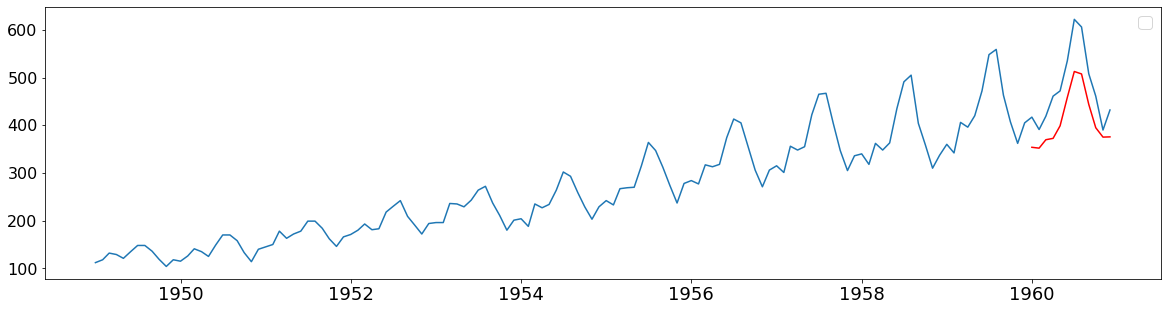

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Passengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()